### Key Questions

What transformations can be used in TensorBBox??

### Questions
1. How to fix a batch and keep drawing it? (apply different augmentations at different draws)?
2. How to replicate a transformation pipeline same as aug_transforms and apply it on a Dataset samples?

### Conclusions
1. RandomResizedCropGPU causes the problem (it has no type-dispatch on TensorPoint)

In [10]:
import os
import sys
path = os.path.join(os.getcwd(), '..')
sys.path.append(path)

import warnings 
warnings.filterwarnings("ignore")

from fastai2.vision.all import *

from src.data.utils import decode_coco_json, get_img_ids

In [11]:
data_path = Path('/userhome/34/h3509807/wheat-data')

In [15]:
def build_dblock(data_path, resize_sz, norm, rand_seed = 144, test_mode = False):
    json_path = data_path / 'train_mini.json' if test_mode else data_path / 'train.json'
    _, _, img2bbox = decode_coco_json(json_path)
    
    blks = (ImageBlock, BBoxBlock, BBoxLblBlock)
    
    get_ids_func = get_img_ids(json_path)
    getters_func = [lambda o: data_path / 'train' / o, 
                    lambda o: img2bbox[o][0], 
                    lambda o: img2bbox[o][1]]
    
    rand_splitter = RandomSplitter(valid_pct = 0.2, seed = rand_seed)
    batch_tfms = aug_transforms(size = resize_sz, 
                                min_scale = 1., 
                                do_flip = True)
    if norm: 
        batch_tfms += [Normalize.from_stats(*imagenet_stats)]
    
    dblock = DataBlock(
        blocks = blks, splitter = rand_splitter,
        get_items = get_ids_func, getters = getters_func,
        batch_tfms = batch_tfms, n_inp = 1
        )
    return dblock

def build_dataloaders(
    data_path, bs, resize_sz = 256, 
    norm = False, rand_seed = 144, test_mode = False
):
    """
    :param:
        data_path : str/ Path, path to wheat datasets
        resize_sz : int, length after resized (assume square)
        rand_seed : int, andom seed id
    """
    if isinstance(data_path, str):
        data_path = Path(data_path)
        
    dblk = build_dblock(data_path, resize_sz, norm = norm, 
                        rand_seed = rand_seed, test_mode = test_mode)
    dls = dblk.dataloaders(data_path / 'train', bs = bs)
    dls.c = 2
    return dls

In [16]:
dls = build_dataloaders(data_path, bs = 8, 
                        norm = True, test_mode = True)

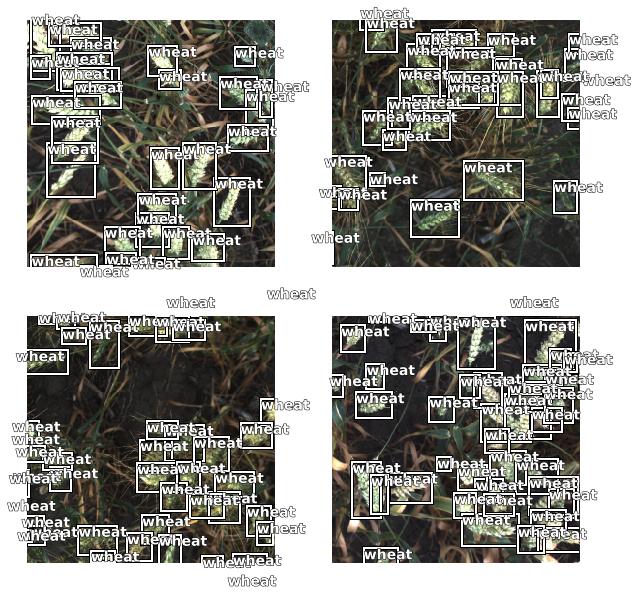

In [34]:
b = dls.one_batch()
dls.show_batch(b = b, max_n = 4, figsize = (10, 10));

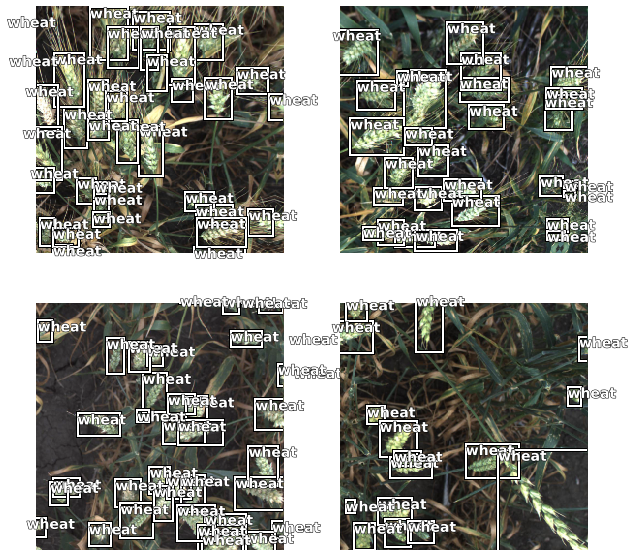

In [35]:
b = dls.one_batch()
dls.show_batch(b = b, max_n = 4, figsize = (10, 10));

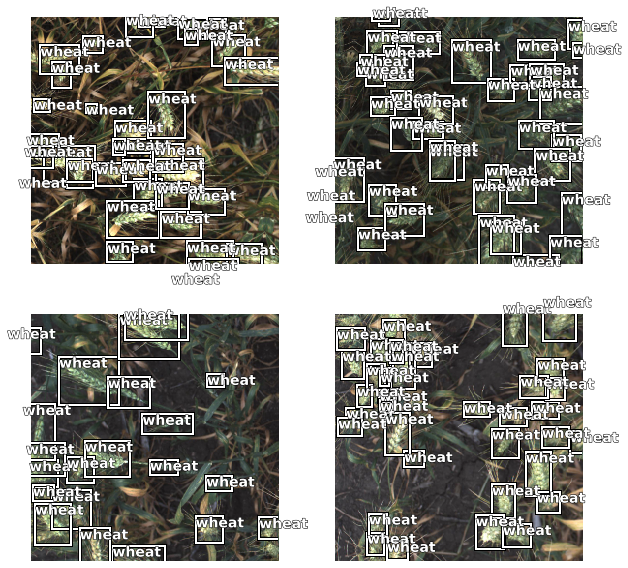

In [36]:
b = dls.one_batch()
dls.show_batch(b = b, max_n = 4, figsize = (10, 10));